In [4]:
# numpy is fast, but jax jit for xla compilation?
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', ['lightgrey', 'white'])
from time import perf_counter
from functools import cache


In [ ]:
# internally the board object is using refactored integer positions

In [1]:

class board_obj():
    def __init__(self):
        # the full board: two channels, one per player
        self.markers = np.zeros((9,9,2)).astype(bool)
        # an "open" location is calculated by ORing
        
        # the overall miniboard status
        self.miniboxes = np.zeros((3,3,3)).astype(bool)
        # channels: p1, p2, stale
        
        # board history
        self.hist = np.zeros((81,2),dtype=np.uint8)
        self.n_moves = 0

In [5]:
class ops4():
    lines_mask = np.array([[1,1,1,0,0,0,0,0,0], # horizontals
                       [0,0,0,1,1,1,0,0,0],
                       [0,0,0,0,0,0,1,1,1],
                       [1,0,0,1,0,0,1,0,0], # verticals
                       [0,1,0,0,1,0,0,1,0],
                       [0,0,1,0,0,1,0,0,1],
                       [1,0,0,0,1,0,0,0,1], # diagonals
                       [0,0,1,0,1,0,1,0,0]],dtype=bool).reshape(-1,3,3)
        
    @staticmethod
    def get_player(board_obj: board_obj) -> int:
        return board_obj.n_moves%2 
    
    @staticmethod
    def make_move(board_obj: board_obj, move:tuple) -> None:
        
        # update move history
        board_obj.hist[board_obj.n_moves] = move
        
        # update board for player

        board_obj.markers[move[0],move[1], board_obj.n_moves%2] = True

        # if check line, update finished
        if ops4.check_minibox_lines(board_obj, move):
            board_obj.miniboxes[move[0]//3, move[1]//3, board_obj.n_moves%2] = True
            board_obj.n_moves += 1
            return

        # check stale
        mini_board_idx = move[0]//3, move[1]//3

        if np.all(np.any(board_obj.markers[mini_board_idx[0]*3:(mini_board_idx[0]+1)*3,
                                           mini_board_idx[1]*3:(mini_board_idx[1]+1)*3],axis=2)):
            board_obj.miniboxes[mini_board_idx[0],mini_board_idx[1],2] = True
            
        # update history index
        board_obj.n_moves += 1
    
    @staticmethod
    def undo_move(board_obj: board_obj) -> None:
        if board_obj.n_moves == 0:
            print('no moves, returning null')
            return
        # update history and index
        _move = np.copy(board_obj.hist[board_obj.n_moves-1])

        board_obj.hist[board_obj.n_moves-1] = [0,0]
        
        # clear player markers (don't need to check for players)
        board_obj.markers[_move[0],_move[1],:] = False
        
        # open that miniboard (the move was either the last move on that board or it was already open)
        board_obj.miniboxes[_move[0]//3,_move[1]//3,:] = False
        
        # update index
        board_obj.n_moves -= 1
        

    @staticmethod
    def get_valid_moves(board_obj:board_obj) -> list[tuple[int]]:
        
        # all non-markered positions
        all_valid = (np.any(board_obj.markers,axis=2) == False)
        
        # initialization problem
        if board_obj.n_moves == 0:
            return list(zip(*np.where(all_valid)))

        # calculate last move's relative position
        _last_move = board_obj.hist[board_obj.n_moves-1]
        _rel_pos = _last_move[0] % 3, _last_move[1] % 3 # which minibox position is this
        
        # ---- 'play anywhere' branch -----
        # if minibox is finished
        if np.any(board_obj.miniboxes[_rel_pos[0],_rel_pos[1]]):
            # create "finished_box mask"
            finished_mask = np.zeros((9,9),dtype=bool)
            # loop through each finished box
            temp_in = np.any(board_obj.miniboxes,axis=2)
            for _box_finished, _flag in zip(zip(*np.where(temp_in==False)),temp_in.flatten()):
                if _flag:
                    finished_mask[_box_finished[0]*3:(_box_finished[0]+1)*3,
                                  _box_finished[1]*3:(_box_finished[1]+1)*3] = False
            return list(zip(*np.where(all_valid | finished_mask)))
        
        # mask to miniboard
        mini_mask = np.zeros((9,9),dtype=bool)
        mini_mask[_rel_pos[0]*3:(_rel_pos[0]+1)*3,
                  _rel_pos[1]*3:(_rel_pos[1]+1)*3] = True
        
        return list(zip(*np.where(all_valid & mini_mask)))

    @staticmethod
    def check_move_is_valid(board_obj: board_obj, move: tuple) -> bool:
        return move in ops4.get_valid_moves(board_obj)
    
    @staticmethod
    def check_minibox_lines(board_obj: board_obj, move: int) -> bool:
        ''' checks whether the last move created a line '''
        # get player channel by move number
        _player_channel = board_obj.n_moves%2
        
        # select the minibox and relative position
        _temp_minibox_idx = move[0]//3, move[1]//3
        _rel_pos = move[0]%9, move[1]%9
        
        # the nested index below reduces the number of things to loop over
        _temp_mini = board_obj.markers[_temp_minibox_idx[0]*3:(_temp_minibox_idx[0]+1)*3,
                                       _temp_minibox_idx[1]*3:(_temp_minibox_idx[1]+1)*3,
                                       _player_channel]

        # check lines in that miniboard
        for _line in ops4.lines_mask:
            if np.all(_temp_mini & _line == _line):
                return True
                
        return False
    
    @staticmethod
    def check_game_finished(board_obj: board_obj) -> bool:
        ''' not a check whether it IS finished, but if the most recent move finished it '''
        
        _player_channel = (board_obj.n_moves-1)%2
        
        # check if last active player made a line in the miniboxes
        for _line in ops4.lines_mask:
            if np.all(board_obj.miniboxes[:,:,_player_channel] * _line == _line):
                # game is finished
                return True
        
        # all miniboxes filled
        # (if all of them are filled will return true, otherwise will return false
        return np.all(np.any(my_board.miniboxes,axis=2))
    
    @staticmethod
    def pull_dictionary(board_obj: board_obj) -> dict:
        # dictionary, active miniboard, valid moves in the original format
        temp_dict = {}

        # make array (the main thing)
        temp_array = np.zeros((9,9))
        temp_array[board_obj.markers[:,:,0]] = 1
        temp_array[board_obj.markers[:,:,1]] = -1
        temp_dict['board_state'] = temp_array
        if board_obj.n_moves%2 == 1:
            temp_dict['board_state'] *= -1 # flip perspectives based on player
        
        # calculate active miniboard
        _last_move = board_obj.hist[board_obj.n_moves-1]
        _rel_pos = _last_move[0] % 3, _last_move[1] % 3

        if np.any(board_obj.miniboxes[_rel_pos[0],_rel_pos[1]]):
            temp_dict['active_box'] = (-1,-1)
        else:
            temp_dict['active_box'] = (_rel_pos[0],_rel_pos[1])

        # valid moves (converted to tuples)
        temp_dict['valid_moves'] = ops4.get_valid_moves(board_obj)
        return temp_dict
    
    @staticmethod # to be used infrequently, not efficient and rarely needed
    def get_winner(board_obj: board_obj) -> str:
        # check agent 1
        for _line in ops.lines_mask:
            if np.all(my_board.miniboxes[:,:,0] * _line == _line):
                return 'agent 1 wins'

        # check agent 2
        for _line in ops.lines_mask:
            if np.all(my_board.miniboxes[:,:,1] * _line == _line):
                return 'agent 2 wins'

        # check stale
        if np.all(np.any(my_board.miniboxes,axis=2)): # if all miniboards are filled with something
            return 'stale'

        return 'game is ongoing'

In [167]:
#ops4.get_valid_moves(my_board)
#ops4.get_valid_moves(my_board))np.random.choice(len(ops4.get_valid_moves(my_board)))
#list(zip(*np.where(ops4.get_valid_moves(board_obj))))
#valid_moves = ops4.get_valid_moves(my_board)
#plt.imshow(my_board.markers[:,:,1])
ops4.undo_move(my_board)
#ops4.get_valid_moves(my_board)


In [6]:
my_board = board_obj()

while not ops4.check_game_finished(my_board):
    valid_moves = ops4.get_valid_moves(my_board)
    random_move_idx = np.random.choice(len(valid_moves))
    ops4.make_move(my_board,valid_moves[random_move_idx])


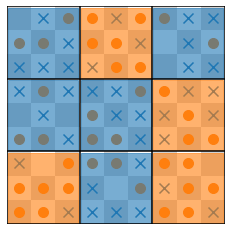

In [7]:

def checkerboard(shape):
    # from https://stackoverflow.com/questions/2169478/how-to-make-a-checkerboard-in-numpy
    # for visualization
    return np.indices(shape).sum(axis=0) % 2

def _check_line(box):
    '''
    box is a (3,3) array
    returns True if a line is found
    '''
    for i in range(3):
        if abs(sum(box[:,i])) == 3: return True # horizontal
        if abs(sum(box[i,:])) == 3: return True # vertical

    # diagonals
    if abs(box.trace()) == 3: return True
    if abs(np.rot90(box).trace()) == 3: return True
    # no line found
    return False

def calc_finished_boxes(temp_dict):
    ''' only used in plotting '''
    temp_finished = np.zeros((3,3,3))
    for i in range(3):
        for j in range(3):
            temp_box = temp_dict['board_state'][i*3:(i+1)*3][:,j*3:(j+1)*3]
            # p1
            temp_box_p1 = (temp_box == 1)
            temp_finished[i,j,0] = _check_line(np.clip(temp_box_p1,0,1))
            # p2
            temp_box_p2 = (temp_box == -1)
            temp_finished[i,j,1] = _check_line(np.clip(temp_box_p2,0,1))
            # stale
            if sum(temp_finished[i,j]) == 0:
                temp_finished[i,j,2] = abs(temp_box).sum() == 9
    return temp_finished

def fancy_draw_board(board_obj, marker_size: int = 100) -> None:
    # pull board information (marker and miniboxes)
    temp_dict = ops4.pull_dictionary(board_obj)
    # flip board state for visualization of p2's turn.
    if my_board.n_moves%2 == 1:
        temp_dict['board_state'] *= -1
        
    plt.imshow(checkerboard((9,9)), cmap=cmap, origin='lower')
    for i in [-0.5,2.5,5.5, 8.5]:
        plt.axvline(i,c='k')
        plt.axhline(i,c='k')
    plt.axis('off')

    # markers
    plt.scatter(*np.where(temp_dict['board_state'] == -1),
                marker='x',s=marker_size,c='tab:blue')
    plt.scatter(*np.where(temp_dict['board_state'] == 1),
                marker='o',s=marker_size,c='tab:orange')

    # miniboard markers
    finished_boxes = calc_finished_boxes(temp_dict)
    x_boxes = np.where(finished_boxes[:,:,1] == 1)
    o_boxes = np.where(finished_boxes[:,:,0] == 1)
    plt.scatter(x_boxes[0]*3+1,x_boxes[1]*3+1,
                marker='s',s=marker_size*50,alpha=0.6,c='tab:blue')
    plt.scatter(o_boxes[0]*3+1,o_boxes[1]*3+1,
                marker='s',s=marker_size*50,alpha=0.6,c='tab:orange')

    stale_boxes = np.where(finished_boxes[:,:,2] == 1)
    plt.scatter(stale_boxes[0]*3+1,stale_boxes[1]*3+1,
                marker='s',s=marker_size*50,alpha=0.3,c='k')

fancy_draw_board(my_board)

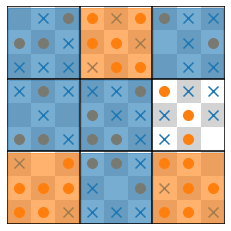

In [8]:
ops4.undo_move(my_board)
ops4.pull_dictionary(my_board)
fancy_draw_board(my_board)

## bots

In [9]:
class random_bot:
    '''
    this bot selects a random valid move
    '''
    def __init__(self, name = 'beep-boop'):
        self.name = name
    def move(self, board_dict):
        random_index = np.random.choice(len(board_dict['valid_moves']))
        return board_dict['valid_moves'][random_index]

In [10]:
class line_completer_bot:
    '''
    tries to complete lines, otherwise it plays randomly
    designed to show how to implement a relatively simple strategy
    '''
    
    ''' ------------------ required function ---------------- '''
    
    def __init__(self,name: str = 'Chekhov') -> None:
        self.name = name
        self.box_probs = np.ones((3,3)) # edges
        self.box_probs[1,1] = 4 # center
        self.box_probs[0,0] = self.box_probs[0,2] = self.box_probs[2,0] = self.box_probs[2,2] = 2 # corners
        
    def move(self, board_dict: dict) -> tuple:
        ''' wrapper
        apply the logic and returns the desired move
        '''
        return tuple(self.heuristic_mini_to_major(board_state = board_dict['board_state'],
                                                  active_box = board_dict['active_box'],
                                                  valid_moves = board_dict['valid_moves']))
    
    
    ''' --------- generally useful bot functions ------------ '''
    
    def _check_line(self, box: np.array) -> bool:
        '''
        box is a (3,3) array
        returns True if a line is found, else returns False '''
        for i in range(3):
            if abs(sum(box[:,i])) == 3: return True # horizontal
            if abs(sum(box[i,:])) == 3: return True # vertical

        # diagonals
        if abs(box.trace()) == 3: return True
        if abs(np.rot90(box).trace()) == 3: return True
        return False

    def _check_line_playerwise(self, box: np.array, player: int = None):
        ''' returns true if the given player has a line in the box, else false
        if no player is given, it checks for whether any player has a line in the box'''
        if player == None:
            return self._check_line(box)
        if player == -1:
            box = box * -1
        box = np.clip(box,0,1)
        return self._check_line(box)
    
    def pull_mini_board(self, board_state: np.array, mini_board_index: tuple) -> np.array:
        ''' extracts a mini board from the 9x9 given the its index'''
        temp = board_state[mini_board_index[0]*3:(mini_board_index[0]+1)*3,
                           mini_board_index[1]*3:(mini_board_index[1]+1)*3]
        return temp

    def get_valid(self, mini_board: np.array) -> np.array:
        ''' gets valid moves in the miniboard'''
#        print(mini_board)
#        print(np.where(mini_board == 0))
#        return np.where(mini_board == 0)
        return np.where(abs(mini_board) != 1)

    def get_finished(self, board_state: np.array) -> np.array:
        ''' calculates the completed boxes'''
        self_boxes = np.zeros((3,3))
        opp_boxes = np.zeros((3,3))
        stale_boxes = np.zeros((3,3))
        # look at each miniboard separately
        for _r in range(3):
            for _c in range(3):
                player_finished = False
                mini_board = self.pull_mini_board(board_state, (_r,_c))
                if self._check_line_playerwise(mini_board, player = 1):
                    self_boxes[_r,_c] = 1
                    player_finished = True
                if self._check_line_playerwise(mini_board, player = -1):
                    opp_boxes[_r,_c] = 1
                    player_finished = True
                if (sum(abs(mini_board.flatten())) == 9) and not player_finished:
                    stale_boxes[_r,_c] = 1

        # return finished boxes (separated by their content)
        return (self_boxes, opp_boxes, stale_boxes)
    
    def complete_line(self, mini_board: np.array) -> list:
        if sum(abs(mini_board.flatten())) == 9:
            print('invalid mini_board') # should never reach here
        # works as expected, however mini-board sometimes is sometimes invalid
        ''' completes a line if available '''
        # loop through valid moves with hypothetic self position there.
        # if it makes a line it's an imminent win
        imminent = list()
        valid_moves = self.get_valid(mini_board)
        for _valid in zip(*valid_moves):
            # create temp valid pattern
            valid_filter = np.zeros((3,3))
            valid_filter[_valid[0],_valid[1]] = 1
            if self._check_line(mini_board + valid_filter):
                imminent.append(_valid)
        return imminent
    
    def get_probs(self, valid_moves: list) -> np.array:
        ''' match the probability with the valid moves to weight the random choice '''
        valid_moves = np.array(valid_moves)
        probs = list()
        for _valid in np.array(valid_moves).reshape(-1,2):
            
            probs.append(self.box_probs[_valid[0],_valid[1]])
        probs /= sum(probs) # normalize
        return probs
    
    ''' ------------------ bot specific logic ---------------- '''
    
    def heuristic_mini_to_major(self,
                                board_state: np.array,
                                active_box: tuple,
                                valid_moves: list) -> tuple:
        '''
        either applies the heuristic to the mini-board or selects a mini-board (then applies the heuristic to it)
        '''
        if active_box != (-1,-1):
            # look just at the mini board
            mini_board = self.pull_mini_board(board_state, active_box)
            # look using the logic, select a move
            move = self.mid_heuristic(mini_board)
            # project back to original board space
            return (move[0] + 3 * active_box[0],
                    move[1] + 3 * active_box[1])

        else:
        #    print(np.array(valid_moves).shape) # sometimes the miniboard i'm sent to has no valid moves
        
            # use heuristic on finished boxes to select which box to play in
            imposed_active_box = self.major_heuristic(board_state)
#            print(self.pull_mini_board(board_state, imposed_active_box),'\n')
#            print('\n')

            # call this function with the self-imposed active box
            return self.heuristic_mini_to_major(board_state = board_state,
                                                active_box = imposed_active_box,
                                                valid_moves = valid_moves)

    def major_heuristic(self, board_state: np.array) -> tuple:
        '''
        determines which miniboard to play on
        note: having stale boxes was causing issues where the logic wanted to block
              the opponent but that mini-board was already finished (it was stale)
        '''
        z = self.get_finished(board_state)
        # finished boxes is a tuple of 3 masks: self, opponent, stale 
        self_boxes  = z[0]
        opp_boxes   = z[1]
        stale_boxes = z[2]
#        print('self:\n',self_boxes)
#        print('opp :\n',opp_boxes)
#        print('stale:\n',stale_boxes)
        
        # ----- identify imminent wins -----
        imminent_wins = self.complete_line(self_boxes)
#        print('len imminent win:',len(imminent_wins))
        # remove imminent wins that point to stale boxes (or opponent)
        stale_boxes_idxs = zip(*np.where(stale_boxes))
        for stale_box in stale_boxes_idxs:
            if stale_box in imminent_wins:
                imminent_wins.remove(stale_box)
        opp_boxes_idx = zip(*np.where(opp_boxes))
        for opp_box in opp_boxes_idx:
            if opp_box in imminent_wins:
                imminent_wins.remove(opp_box)
        # if it can complete a line, do it
        if len(imminent_wins) > 0: 
#            print('returning line')
#            print('len imminent win:',len(imminent_wins))
            return imminent_wins[np.random.choice(len(imminent_wins), p=self.get_probs(imminent_wins))]

        # ------ attempt to block -----
        imminent_loss = self.complete_line(opp_boxes)
        # make new list to remove imminent wins that point to stale boxes
        stale_boxes_idx = zip(*np.where(stale_boxes))
        for stale_box in stale_boxes_idx:
            if stale_box in imminent_loss:
                imminent_loss.remove(stale_box)
        self_boxes_idx = zip(*np.where(self_boxes))
        for self_box in self_boxes_idx:
            if self_box in imminent_loss:
                imminent_loss.remove(self_box)
        if len(imminent_loss) > 0:
#            print('returning block')
            return imminent_loss[np.random.choice(len(imminent_loss), p=self.get_probs(imminent_loss))]

        # ------ else take random ------
#        print('returning random')
        internal_valid = np.array(list(zip(*self.get_valid(self_boxes + opp_boxes + stale_boxes))))
        return tuple(internal_valid[np.random.choice(len(internal_valid), p=self.get_probs(internal_valid))])
        
    def mid_heuristic(self, mini_board: np.array) -> tuple:
        ''' main mini-board logic '''
        # try to complete a line on this miniboard
        imminent_wins = self.complete_line(mini_board)
        if len(imminent_wins) > 0:
            return imminent_wins[np.random.choice(len(imminent_wins))]

        ''' attempt to block'''
        imminent_wins = self.complete_line(mini_board * -1) # pretend to make lines from opponent's perspective
        if len(imminent_wins) > 0:
            return imminent_wins[np.random.choice(len(imminent_wins))]

        # else play randomly
        valid_moves = np.array(list(zip(*self.get_valid(mini_board))))
        return tuple(valid_moves[np.random.choice(len(valid_moves), p=self.get_probs(valid_moves))])



## /bots

In [11]:
agent1 = line_completer_bot()
agent2 = random_bot(name='rando')

agent1_times = list()
agent2_times = list()

win_counter = 0 # quick integer check to see whether line bot wins more than loses

for _ in range(100): # replicate over 100 games
#    print(f'---- game {_} ----')
    my_board = board_obj()
    for i in range(81): # or a while loop that looks at my_board.n_moves
        ''' agent 1 turn'''

        # get dictionary 
        temp_dict = ops4.pull_dictionary(my_board)
        # give dict to agent, calculate move
        start = perf_counter()
        agent1_move = agent1.move(temp_dict)
        agent1_times.append(perf_counter()-start)
        # validate the move
        if not ops4.check_move_is_valid(my_board, agent1_move):
            print(f'invalid move selected by p1, defaulting to random. {agent1_move}') # <<<< or a better debug message / break
            raise TypeError

        # make the move
        ops4.make_move(my_board, agent1_move)
        # check whether game is finished
        if ops4.check_game_finished(my_board):
            win_counter += 1
            break

        ''' agent 2 turn '''
        # get dictionary 
        temp_dict = ops4.pull_dictionary(my_board)
        # give dict to agent, calculate move
        start = perf_counter()
        agent2_move = agent2.move(temp_dict)
        agent2_times.append(perf_counter()-start)
        # validate the move
        if not ops4.check_move_is_valid(my_board, agent2_move):
            print(f'invalid move selected by p2, defaulting to random, {agent2_move}') # <<<< or a better debug message / break
            raise Error
        # make the move
        ops4.make_move(my_board, agent2_move)
        # check whether game is finished
        if ops4.check_game_finished(my_board):
            win_counter -= 1
            break


In [12]:
win_counter

98

In [13]:
agent2 = line_completer_bot()
agent1 = random_bot(name='rando')

agent1_times = list()
agent2_times = list()

win_counter = 0 # quick integer check to see whether line bot wins more than loses

for _ in range(100): # replicate over 100 games
    my_board = board_obj()
    for i in range(81): # or a while loop that looks at my_board.n_moves
        ''' agent 1 turn'''

        # get dictionary 
        temp_dict = ops4.pull_dictionary(my_board)
        # give dict to agent, calculate move
        start = perf_counter()
        agent1_move = agent1.move(temp_dict)
        agent1_times.append(perf_counter()-start)
        # validate the move
        if not ops4.check_move_is_valid(my_board, agent1_move):
            raise Exception(f"invalid move from p1({agent1_move})! break")

        # make the move
        ops4.make_move(my_board, agent1_move)
        # check whether game is finished
        if ops4.check_game_finished(my_board):
            win_counter += 1
            break

        ''' agent 2 turn '''
        # get dictionary 
        temp_dict = ops4.pull_dictionary(my_board)
        # give dict to agent, calculate move
        start = perf_counter()
        agent2_move = agent2.move(temp_dict)
        agent2_times.append(perf_counter()-start)
        # validate the move
        if not ops4.check_move_is_valid(my_board, agent2_move):
            raise Exception(f"invalid move from p1({agent2_move})! break")
            
        # make the move
        ops4.make_move(my_board, agent2_move)
        # check whether game is finished
        if ops4.check_game_finished(my_board):
            win_counter -= 1
            break


In [14]:
win_counter

-96

In [15]:
''' convert list of tuples to symbols for nathan's visualization '''

def unconvert_log(symbol):
    ''' part of loading a game from a string '''
    offset = 32
    int_position = ord(symbol) - offset
    return (int_position//9, int_position%9)

In [16]:
def cvt_vis_app(board_obj) -> str:
    ''' converts a game board to a string for visualization with the app '''
    return ''.join([(chr(_p[0]*9 + _p[1] + 32)) for _p in board_obj.hist[:board_obj.n_moves]])
ops4.undo_move(my_board)
ops4.undo_move(my_board)
ops4.undo_move(my_board)

cvt_vis_app(my_board)

'pf?6dK@/E>+TZ-QmnV 2joY4gB7]$%:0GMh'

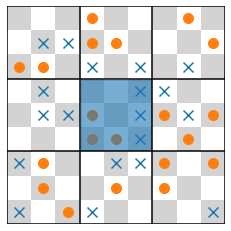

In [18]:
def load_game(game_string:str) -> board_obj:
    temp_board = board_obj()
    debug_log = list()
    ''' plays through a game up to the end of the game log '''
    for idx, encoded_position in enumerate(game_string):
        _move = unconvert_log(encoded_position)
        if not ops4.check_move_is_valid(temp_board,_move):
            played_moves = ''.join(debug_log)
            raise Exception(f'valid moves played - {played_moves} - invalid move - {encoded_position}')
        ops4.make_move(temp_board, _move)
        debug_log.append(encoded_position)
    return temp_board

fancy_draw_board(load_game('C9l[& 2hW.B6Z-G;+A*PjeEQbOgSX0>"/FKRoc?'))